In [2]:
import os
import mpltern
import src.helper as h
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
import matplotlib.pyplot as plt

# DATA GENERATION

observing non-noisy posteriors

In [3]:
n1 = 5000
n = 3*n1 

X = np.random.normal(loc=0.0, scale=1.0, size=(n,10))
beta = np.random.normal(loc=0.0, scale=1.0, size=(10,3))
Z = np.exp(np.matmul(X,beta))
W = Z/Z.sum(axis=1)[:,None]

In [4]:
X_train, X_test, W_train, W_test = train_test_split(X, W, test_size=n1)
X_proper_train, X_calib, W_proper_train, W_calib = train_test_split(X_train, W_train, test_size=n1)

## Classic learning scenario
1. taking the posterior mode as the label for training data
2. using X,y for training a classifier, GB as learner

In [9]:
y_proper_train = []
for i in range(X_proper_train.shape[0]):
    y_proper_train.append(np.argmax(W_proper_train[i]))

y_proper_train = np.array(y_proper_train)

In [10]:
classifier = HistGradientBoostingClassifier(random_state=0).fit(X_proper_train, y_proper_train)

## Calibration (Algorithm 1 in paper)

using X,w for calibration using algorithm 1 with total varation distance as nonconformity score

In [11]:
phat_calib = classifier.predict_proba(X_calib)

cal_scores = []

for i in range(X_calib.shape[0]):
    cal_scores.append(h.tv(phat_calib[i], W_calib[i]))

q = h.compute_quantile(cal_scores, 0.1)

### coverage

In [12]:
phat_test = classifier.predict_proba(X_test)

t = 0
for i in range(X_test.shape[0]):
    t += (h.tv(phat_test[i], W_test[i]) <q)

print("coverage is ", t/X_test.shape[0])

coverage is  0.9016


### Some VISUALIZATION
1. Since simplex space is continuous and we can not calculate the distance between every point in that space and the predicted distribution, we need to discretize the simplex space. 
2. For each element in that finite set, we calculate the distacne to the predicted distribution and if it is less than q, we add it to the prediction set.  

In [13]:
simplex = h.dicrete_simplex(n_samples=500000, n_classes=3)

In [14]:
k = np.random.randint(X_test.shape[0])
ph = phat_test[k]
p = W_test[k]
idx = []
for i in range(simplex.shape[0]):
    if h.tv(ph, simplex[i]) < q:
        idx.append(i)

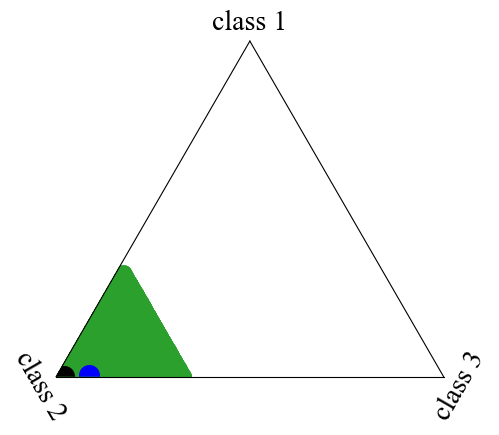

In [15]:
plt.figure(dpi=100, figsize=(5,5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
ax = plt.subplot(projection="ternary")
ax.set_tlabel("class 1")
ax.set_llabel("class 2")
ax.set_rlabel("class 3")
ax.tick_params(tick1On=False, tick2On=False, label1On=False, label2On=False)

ax.scatter(simplex[idx,0], simplex[idx,1], simplex[idx,2], c='tab:green', label="CP set")
ax.scatter(p[0], p[1], p[2], s=200, c='b', label="Ground truth distribution")
ax.scatter(ph[0], ph[1], ph[2], s=200, c='k', label="Predcited distribution")
# plt.savefig(os.path.join("credals", str(h.tv(phat_test[k], W_test[k]) <q)+str(k) + str( [ '%.2f' % elem for elem in p ])+'.pdf'), format='pdf', bbox_inches='tight', pad_inches=0)

## Evidential deep learning scenario
1. taking the posterior mode as the label for training data
2. using X,y for training an evidential deep network

In [49]:
import tensorflow as tf
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from scipy.stats import dirichlet
from mpltern.datasets import get_dirichlet_pdfs

## deep learning model

In [95]:
model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation="relu"),
        # tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(3),
    ])

## specific loss function

In [96]:
lgamma = tf.math.lgamma
digamma = tf.math.digamma

epochs[0] = [1]

def KL(alpha, num_classes=3):
    one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
    S = K.sum(alpha,axis=1,keepdims=True)  

    kl = lgamma(S) - K.sum(lgamma(alpha),axis=1,keepdims=True) +\
    K.sum(lgamma(one),axis=1,keepdims=True) - lgamma(K.sum(one,axis=1,keepdims=True)) +\
    K.sum((alpha - one)*(digamma(alpha)-digamma(S)),axis=1,keepdims=True)
          
    return kl


def loss_func(y_true, output):
    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    p = alpha / S  

    err = K.sum(K.pow((y_true-p),2),axis=1,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)
    
    l =  K.sum(err + var,axis=1,keepdims=True)
    l = K.sum(l)
    
    
    kl =  K.minimum(1.0, epochs[0]/50) * K.sum(KL((1-y_true)*(alpha)+y_true))
    return l + kl

In [97]:
batch_size = 100
model.compile(loss=loss_func, optimizer="adam", metrics=['accuracy'])

In [98]:
enc = OneHotEncoder(handle_unknown='ignore')
y_proper_train_one_hot = enc.fit_transform(y_proper_train.reshape((-1,1))).toarray()

In [99]:
epochs = [1]

for i in tqdm(range(1)):
    model.fit(X_proper_train, y_proper_train_one_hot, batch_size=batch_size, epochs=epochs[0], verbose=0)
    epochs[0]+=1

100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


just to check the performance of the classifier on X,y of the test set

In [100]:
y_test = []
for i in range(X_test.shape[0]):
    y_test.append(np.argmax(W_test[i]))

y_test = np.array(y_test)

In [101]:
y_test_one_hot = enc.fit_transform(y_test.reshape((-1,1))).toarray()
score = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 16.072900772094727
Test accuracy: 0.9147999882698059


## Calibration (Algorithm 2 in paper)

using X,w for calibration using algorithm 2 

In [102]:
phat_calib = model.predict(X_calib) 
evidence_calib = np.maximum(phat_calib, 0)
alpha_calib = evidence_calib + 1 

157/157 [==============================] - 0s 763us/step


In [103]:
cal_scores = []
for i in range(X_calib.shape[0]):
    cal_scores.append(dirichlet.pdf(W_calib[i], alpha_calib[i]))

q = h.compute_quantile(cal_scores, 0.9)

Coverage

In [104]:
phat_test = model.predict(X_test) 
evidence_test = np.maximum(phat_test, 0)
alpha_test = evidence_test + 1  


t = 0
for i in range(X_test.shape[0]):
    t += ((dirichlet.pdf(W_test[i], alpha_test[i])) >= q)

print("coverage is ", t/X_test.shape[0])

 59/157 [==========>...................] - ETA: 0s

157/157 [==============================] - 0s 850us/step
coverage is  0.8934


In [105]:
q

2.8607267928921467

### Some VISUALIZATION
1. Same strategy for simplex discretization.  
2. For each element in that finite set, if the likelihood is greater than q, it is included in the set. 

In [106]:
k = np.random.randint(X_test.shape[0])
ph = alpha_test[k]/ alpha_test[k].sum()
p = W_test[k]

In [107]:
idx = []
for i in range(simplex.shape[0]):
    if dirichlet.pdf(simplex[i], alpha_test[k]) >= q:
        idx.append(i)

In [108]:
len(idx)

137611

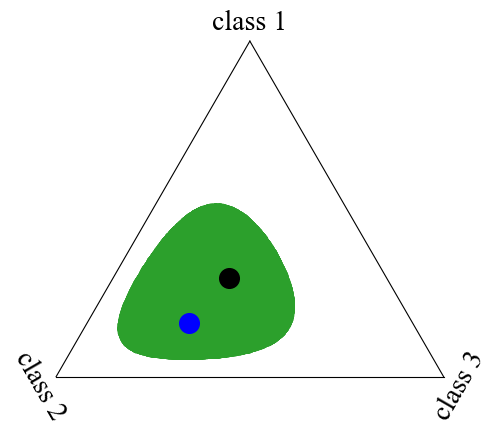

In [109]:
plt.figure(dpi=100, figsize=(5,5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
ax = plt.subplot(projection="ternary")
ax.set_tlabel("class 1")
ax.set_llabel("class 2")
ax.set_rlabel("class 3")
ax.tick_params(tick1On=False, tick2On=False, label1On=False, label2On=False)

ax.scatter(simplex[idx,0], simplex[idx,1], simplex[idx,2], c='tab:green', label="CP set")
ax.scatter(p[0], p[1], p[2], s=200, c='b', label="Ground truth distribution")
ax.scatter(ph[0], ph[1], ph[2], s=200, c='k', label="Predcited distribution")

# plt.savefig(os.path.join("credals_ev", str((dirichlet.pdf(W_test[k], alpha_test[k])) >= q)+str(k) + str( [ '%.2f' % elem for elem in p ])+'.pdf'), format='pdf', bbox_inches='tight', pad_inches=0)


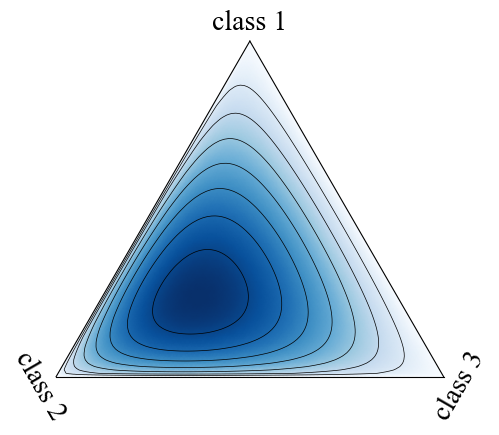

In [110]:
plt.figure(dpi=100, figsize=(5,5))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
ax = plt.subplot(projection="ternary")
ax.set_tlabel("class 1")
ax.set_llabel("class 2")
ax.set_rlabel("class 3")   
ax.tick_params(tick1On=False, tick2On=False, label1On=False, label2On=False)


cmap = "Blues"
shading = "gouraud"
t, l, r, v = get_dirichlet_pdfs(n=100, alpha=alpha_test[k])
cs = ax.tripcolor(t, l, r, v, cmap=cmap, shading=shading, rasterized=True)
ax.tricontour(t, l, r, v, colors="k", linewidths=0.5)

# plt.savefig(os.path.join("credals_ev", str((dirichlet.pdf(W_test[k], alpha)) >= q)+str(k) + str( [ '%.2f' % elem for elem in p ])+'dirichlet.pdf'), format='pdf', bbox_inches='tight', pad_inches=0)